![](header.jpg)

# Image Compression Methods

Kevin J. Walchko, Phd

10 June 2020

---

BLUF: The OpenCV JPEG compression has a high default lossy value. Compressed images create large number of artifacts but result in very small file size. However, for image processing and computer vision, the preference is to use compression but retain the original pixel values. Prefer using a lossless format like PNG where data size is reduced 40% but no differnces between original image and image after uncompression.

There is the possibility of changing JPEG compression parameters to reduce this issue, but prefer an out-of-the-box solution.

## Overview

Sending data between computer processes needs an efficient method of serialization. Images are typically very large and sending raw bytes can reduce bandwdith. Ideally we want to reduce the amount of data that needs to be sent, but ensure we can recover all of it back. JPEG is a common format to compress images, but it is a lossy format and information (maybe important information) will be lost. Other formats like JPEG2000 and PNG have the ability for large compression, but are lossless formats, so you do not loose data. This is just a quick test to see what compression ratios and data losses occur using the OpenCV compression libraries.

In [1]:
from matplotlib import pyplot as plt 
import pylab    

import cv2
import numpy as np
import time
from collections import namedtuple
import attr

from opencv_camera import bgr2rgb, bgr2gray

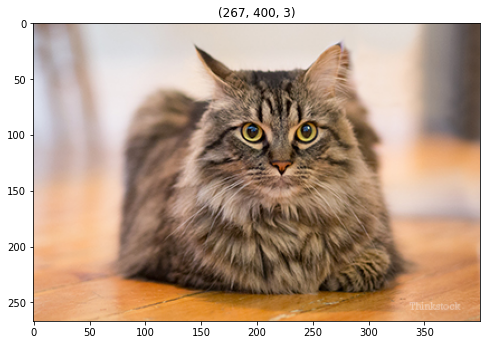

In [3]:
img = cv2.imread("cat.jpg")
img = bgr2rgb(img)

plt.subplots(1,1,figsize=(8,8))
plt.imshow(img)
plt.title("{}".format(img.shape));

In [61]:
@attr.s(slots=True)
class image_st:
    """
    This is the message passed from process to process.
    shape: (rows, cols, planes)
    bytes: array of bytes that are or aren't compressed
    compressed: are the bytes compressed? True/False
    timestamp: unix timestamp
    """
    shape = attr.ib()
    bytes = attr.ib()
    compressed = attr.ib(default=False)
    timestamp = attr.ib(default=time.time())
    
    def uncompress(self):
        img = np.frombuffer(self.bytes, dtype=np.uint8)

        if self.compressed:
            if len(self.shape) == 3:
                img = cv2.imdecode(img, cv2.IMREAD_COLOR)
            else:
                img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)

        img = img.reshape(self.shape)
        return img
    
    def __str__(self):
        if self.compressed:
            s = f"CompressedImage{self.shape} timestamp: {self.timestamp}"
        else:
            s = f"Image{self.shape} timestamp: {self.timestamp}"
        return s

    

def serialize_image(img, compression=None):
    """
    Helper function to create a message from an image and optionally use compression.
    """
    if compression:
        compressed = True
        data = cv2.imencode(compression, img)[1]
    else:
        compressed = False
        data = img.tobytes()

    return image_st(img.shape, data, compressed)


def perf(img, fmt):
    imc = serialize_image(img, fmt)
    im = imc.uncompress()
    
    diff = (img - im).sum()

    plt.subplots(1,2,figsize=(20,8))
    plt.subplot(1,2,1)
    if len(im.shape) == 2:
        plt.imshow(im, cmap="gray")
    else:
        plt.imshow(im)
    plt.title(f"{im.shape}");
    plt.subplot(1,2,2)
    plt.imshow(img - im)
    plt.title(f"Equal: {np.array_equal(img, im)};      Diff: {diff}");
    
    if len(img.shape) == 3:
        r,c,s = img.shape
    else:
        r,c = img.shape
        s = 1
    
    ubytes = r*c*s
    print(f">> Uncompressed size: {ubytes} bytes")
    print(f">> Compressed size: {len(imc.bytes)} bytes")
    print(f">> Data ratio (uncomp/comp): {ubytes/len(imc.bytes)*100:.1f}%")

# Color Images

## Uncompressed

For comparision, let's start with **no** compression. This will serve as the baseline.

>> Uncompressed size: 320400 bytes
>> Compressed size: 320400 bytes
>> Data ratio (uncomp/comp): 100.0%


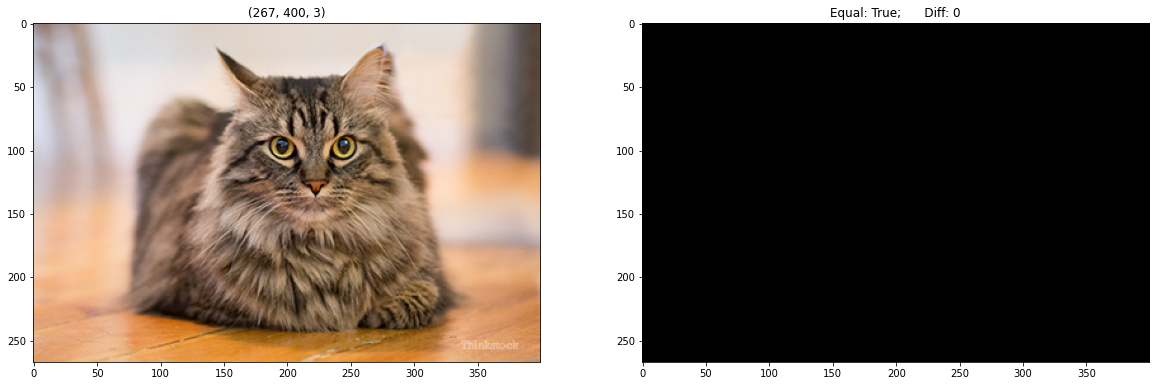

In [66]:
perf(img, None)

## JPEG

JPEG is an old compression that can achieve high compression rates, but is *lossy* because it throws away data inorder to achieve high compression. Generally, the data that is lost is not noticed by the human eye, unless JPEG is told to acheive even higher compression rates, then artifacts begin to appear.

>> Uncompressed size: 320400 bytes
>> Compressed size: 39480 bytes
>> Data ratio (uncomp/comp): 811.6%


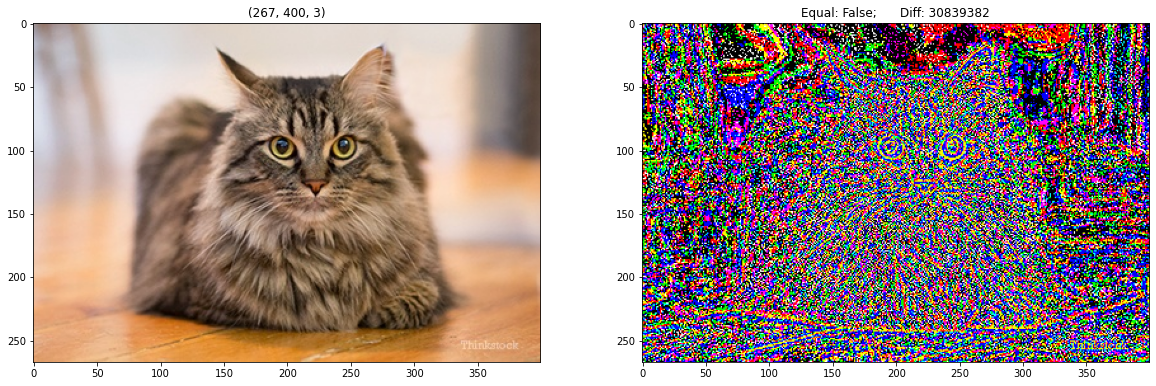

In [57]:
perf(img, '.jpg')

## JPEG2000

In [59]:
perf(img, '.jp2')

>> Uncompressed size: 320400 bytes
>> Compressed size: 80099 bytes
>> Data ratio (uncomp/comp): 400.0%


## PNG

PNG is a newer popular compression algorithm. While it doesn't achieve the compression abilities that JPEG does, it is *lossless* meaning it does not throw away information. This is useful for a variety of computer vision algorithms where you *need* compression to move information around, but you want the same data that came off of the camera.

>> Uncompressed size: 320400 bytes
>> Compressed size: 190789 bytes
>> Data ratio (uncomp/comp): 167.9%


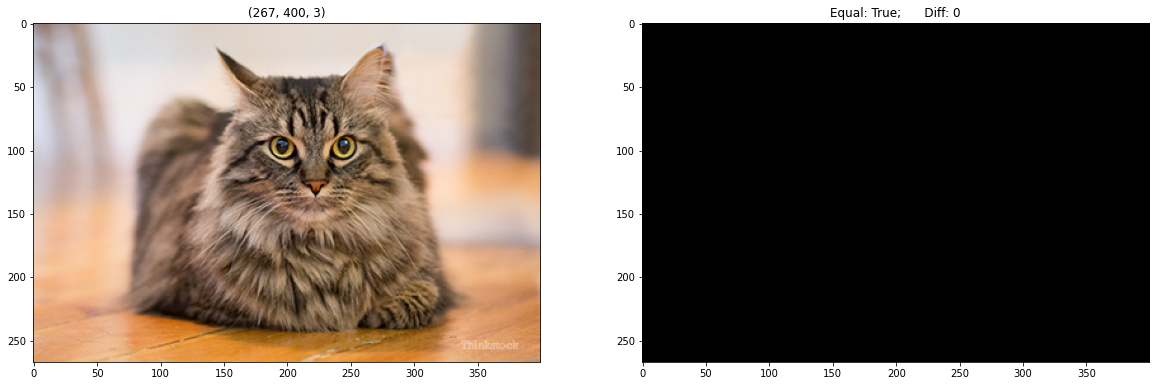

In [58]:
perf(img, '.png')

# Grayscale Images

A lot of computer vision works with grayscale images. This is nice since there is now only a single plane of data rather than three to both transport and process.

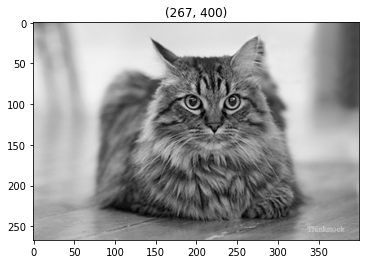

In [37]:
gray = bgr2gray(im)
plt.imshow(gray, cmap='gray')
plt.title("{}".format(gray.shape));

>> Uncompressed size: 106800 bytes
>> Compressed size: 64959 bytes
>> Data ratio (uncomp/comp): 164.4%


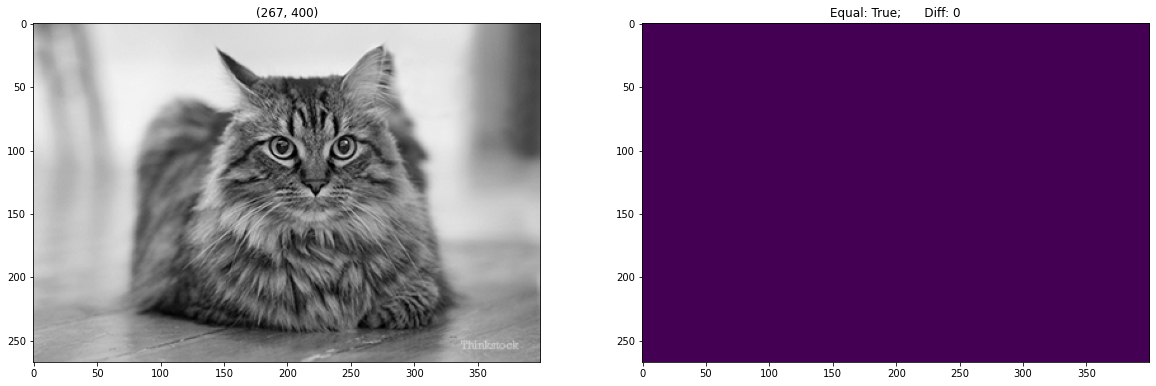

In [62]:
perf(gray, '.png')

>> Uncompressed size: 106800 bytes
>> Compressed size: 34025 bytes
>> Data ratio (uncomp/comp): 313.9%


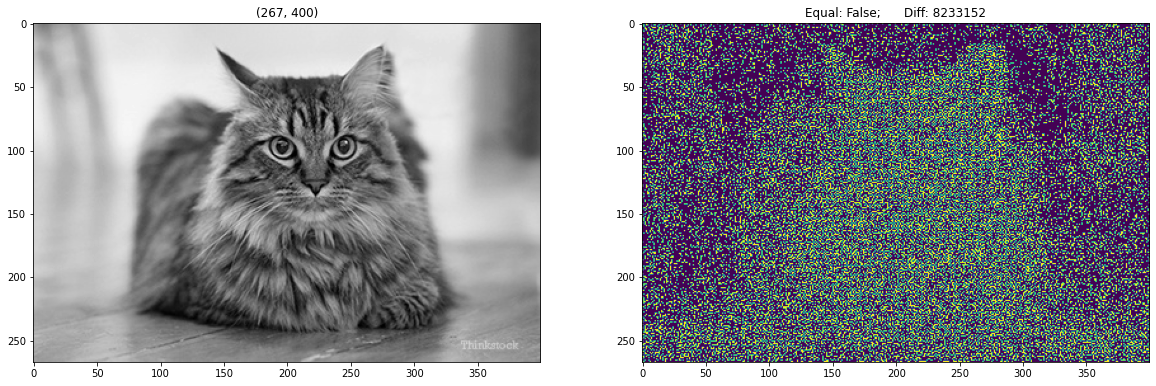

In [63]:
perf(gray, '.jpg')

>> Uncompressed size: 106800 bytes
>> Compressed size: 26542 bytes
>> Data ratio (uncomp/comp): 402.4%


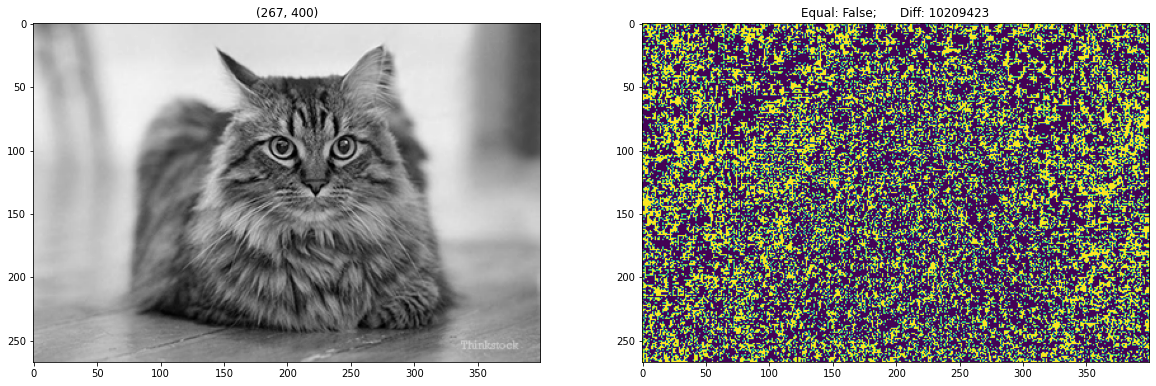

In [64]:
perf(gray, '.jp2')